# Filtragem Automática de SPAM

O objetivo desta conversa é demonstrar alguns conceitos introdutórios de alto nível por trás do aprendizado da máquina (texto).

Um aplicativo para classificar as mensagens SMS do telefone em inglês (bem, o "tipo SMS" do inglês ...) como "spam" ou "ham" (= não spam).

# Preparação do projeto

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

/Users/joaogabriellima/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/joaogabriellima/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/joaogabriellima/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This mod

## Step 1: Load data, look around

Ignorando o primeiro passo real (especificações detalhadas, descobrindo o que queremos estar fazendo - muitas vezes altamente não triviais na prática!), Baixemos o conjunto de dados que estaremos usando nesta demonstração. Vá para https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection e baixe o arquivo zip. Descompacte-o no subdiretório de dados. Você deve ver um arquivo chamado SMSSpamCollection, com cerca de 0,5 MB de tamanho:

Este arquivo contém ** uma coleção de mais de 5 mil mensagens SMS SMS ** (veja o arquivo `readme` para mais informações):

In [3]:
messages = [line.rstrip() for line in open('./SMSSpamCollection')]
print(len(messages))

5574


Uma coleção de textos também é chamado às vezes de "corpus". Vamos imprimir as primeiras dez mensagens neste corpus de SMS:

In [5]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

Nós vemos que este é um [TSV], onde a primeira coluna é uma etiqueta dizendo se a mensagem dada é normal Mensagem ("ham") ou "spam". A segunda coluna é a própria mensagem.

Este corpus será o nosso conjunto de treinamento rotulado. Usando esses exemplos de ham/spam, iremos treinar um modelo de aprendizado de máquina para aprender a discriminar entre ham/spam automaticamente **. Então, com um modelo treinado, poderemos ** classificar mensagens arbitrárias sem letras ** como ham ou spam.

[![](http://radimrehurek.com/data_science_python/plot_ML_flow_chart_11.png)](http://www.astroml.org/sklearn_tutorial/general_concepts.html#supervised-learning-model-fit-x-y)

In [8]:
messages = pandas.read_csv('./SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
messages.head(5)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Com `pandas`, também podemos visualizar estatísticas agregadas facilmente:

In [10]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Há quanto tempo as mensagens?

In [11]:
messages['length'] = messages['message'].map(lambda text: len(text))
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


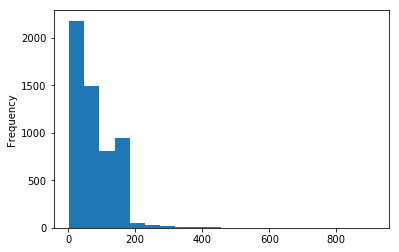

In [12]:
messages.length.plot(bins=20, kind='hist')

In [13]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Qual é essa mensagem super longa?

In [14]:
print(list(messages.message[messages.length > 900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


Existe alguma diferença no comprimento da mensagem entre spam e ham?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119fe6f60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x119ee95f8>], dtype=object)

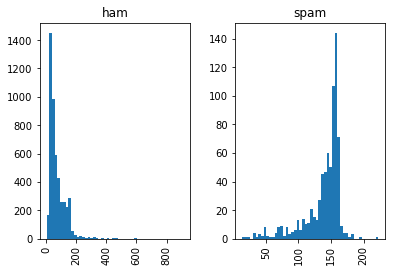

In [15]:
messages.hist(column='length', by='label', bins=50)

Boa diversão, mas como podemos fazer o computador compreender as mensagens de texto simples? Ou pode sob um jargão tão mal formado?

## Etapa 2: pré-processamento de dados

Nesta seção, massaremos as mensagens brutas (seqüência de caracteres) em vetores (seqüências de números).

O mapeamento não é 1-para-1; Usaremos a abordagem [bag-of-words] (http://en.wikipedia.org/wiki/Bag-of-words_model), onde cada palavra única em um texto será representada por um número.

Como primeiro passo, vamos escrever uma função que dividirá uma mensagem em suas palavras individuais:

In [24]:
def split_into_tokens(message):
#     message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

Aqui estão alguns dos textos originais novamente:

In [25]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

... e aqui estão as mesmas mensagens, tokenized:

In [26]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

Perguntas da PNL

1. As maiúsculas carregam informações?
2. A distinção da forma inflexa ("vai" versus "ir") carrega informações?
3. As interjeições, determinantes carregam informações?

Em outras palavras, queremos "normalizar melhor" o texto.

Com o Wordblob, detectamos as tags [parte-de-fala (POS)] (http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) com:

In [27]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

E normalize as palavras na sua forma base ([lemmas] (http://en.wikipedia.org/wiki/Lemmatisation)) com:

In [28]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

Melhor. Você provavelmente pode pensar em muitas outras maneiras de melhorar o pré-processamento: decodificação de entidades HTML (aquelas `&amp;` e `&lt;` vimos acima); Filtrando palavras de parada (pronomes etc); Adicionando mais recursos, como um indicador de palavra-em-todos-limite e assim por diante.

## Passo 3: dados para vetores

Agora, converteremos cada mensagem, representada como uma lista de tokens (lemmas) acima, em um vetor que os modelos de aprendizagem de máquinas podem entender.

Fazer isso exige essencialmente três etapas, no modelo bag-of-words:

1. contando quantas vezes ocorre uma palavra em cada mensagem (freqüência de termo)
2. ponderação das contagens, de modo que tokens freqüentes recebem menor peso (freqüência inversa do documento)
3. normalizando os vetores para o comprimento da unidade, para abstrair do comprimento original do texto (norma L2)

Cada vetor tem tantas dimensões quanto as palavras únicas no corpus de SMS:

In [30]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

8874


Aqui, usamos `scikit-learn` (` sklearn`), uma poderosa biblioteca Python para ensinar a aprendizagem de máquinas. Contém uma multiplicidade de vários métodos e opções.

Vamos pegar uma mensagem de texto e obter suas contagens de bag-of-words como um vetor, colocando em uso o nosso novo `bow_transformer`:

In [31]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [33]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 1158)	1
  (0, 1899)	1
  (0, 2897)	1
  (0, 2927)	1
  (0, 4021)	1
  (0, 6736)	2
  (0, 7111)	1
  (0, 7698)	1
  (0, 8013)	2
(1, 8874)


Então, nove palavras únicas na mensagem nr. 4, dois deles aparecem duas vezes, o resto apenas uma vez. Verificação de sanidade: quais são as palavras que aparecem duas vezes?


In [34]:
print(bow_transformer.get_feature_names()[6736])
print(bow_transformer.get_feature_names()[8013])

say
u


O bag-of-words conta para todo o corpus de SMS são uma matriz grande e dispersa:

In [35]:
messages_bow = bow_transformer.transform(messages['message'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5574, 8874)
number of non-zeros: 80272
sparsity: 0.16%


E, finalmente, após a contagem, o termo ponderação e normalização pode ser feito com [TF-IDF] (http://en.wikipedia.org/wiki/Tf%E2%80%93idf), usando scikit-learn 'TfidfTransformer` :

In [36]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 8013)	0.305114653686
  (0, 7698)	0.225299911221
  (0, 7111)	0.191390347987
  (0, 6736)	0.523371210191
  (0, 4021)	0.456354991921
  (0, 2927)	0.32967579251
  (0, 2897)	0.303693312742
  (0, 1899)	0.24664322833
  (0, 1158)	0.274934159477


Qual é o IDF (freqüência do documento inverso) da palavra `` u ''? De palavra `` university ''?

In [37]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

2.85068150539
8.23975323521


Para transformar todo o corpus do saco de palavras em corpus TF-IDF de uma só vez:

In [38]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5574, 8874)


Há uma infinidade de maneiras pelas quais os dados podem ser projetados e vetados. Esses dois passos, também chamados de "engenharia de recursos", geralmente são as partes mais demoradas e "não desejáveis" da construção de um pipeline preditivo, mas são muito importantes e requerem alguma experiência. O truque é avaliar constantemente: analise o modelo para os erros que ele faz, melhore a limpeza e pré-processamento de dados, faça um brainstorm para novos recursos, avalie

## Etapa 4: Treinar um modelo, detectar spam

Com mensagens representadas como vetores, podemos finalmente treinar nosso classificador de spam / ham. Esta parte é bastante direta, e existem muitas bibliotecas que realizam os algoritmos de treinamento.

Nós estaremos usando scikit-learn here, escolhendo o classificador [Naive Bayes] (http://en.wikipedia.org/wiki/Naive_Bayes_classifier) para começar com:

In [40]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 13.1 ms, sys: 1.17 ms, total: 14.2 ms
Wall time: 13.3 ms


Vamos tentar classificar nossa única mensagem aleatória:

In [75]:
print('predicted:', spam_detector.predict(tfidf4)[0])
print('expected:', messages.label[0])

predicted: ham
expected: ham


Hooray! Você também pode tentar com seus próprios textos.

Uma pergunta natural é perguntar, quantas mensagens classificamos corretamente no geral?

In [43]:
all_predictions = spam_detector.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


In [44]:
print('accuracy', accuracy_score(messages['label'], all_predictions))
print('confusion matrix\n', confusion_matrix(messages['label'], all_predictions))
print('(row=expected, col=predicted)')

accuracy 0.969501255831
confusion matrix
 [[4827    0]
 [ 170  577]]
(row=expected, col=predicted)


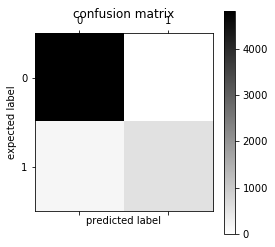

In [45]:
plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

A partir dessa matriz de confusão, podemos calcular precisão e recall, ou sua combinação (harmônica média) F1:

In [47]:
print(classification_report(messages['label'], all_predictions))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5574



Existem algumas métricas possíveis para avaliar o desempenho do modelo. Qual deles é o mais adequado depende da tarefa. Por exemplo, o custo do "spam" como "ham" provavelmente é muito mais baixo do que "ham" como "spam".

## Etapa 5: como executar experimentos?

Na "avaliação" acima, cometemos um pecado cardinal. Por simplicidade de demonstração, avaliamos a precisão nos mesmos dados que usamos para treinamento. ** Nunca avalie no mesmo conjunto de dados em que você treina! Mau! Incesto!**

Essa avaliação não nos diz nada sobre o verdadeiro poder preditivo de nosso modelo. Se simplesmente nos lembrássemos de cada exemplo durante o treinamento, a precisão dos dados de treinamento seria trivialmente 100%, mesmo que não possamos classificar as novas mensagens.

Uma maneira apropriada é dividir os dados em um conjunto de treinamento / teste, onde o modelo só vê os ** dados de treinamento ** durante a montagem do modelo e o ajuste de parâmetros. Os ** dados de teste ** nunca são usados de forma alguma - graças a este processo, nós nos certificamos de que não somos "trapaças", e que nossa avaliação final em dados de teste é representativa da verdadeira performance preditiva.

In [49]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


Assim, conforme solicitado, o tamanho do teste é de 20% do conjunto de dados inteiro (1115 mensagens do total de 5574), e o treinamento é o restante (4459 de 5574).

Vamos recapitular todo o pipeline até este ponto, colocando as etapas explicitamente no `Pipeline` do scikit-learn:

In [50]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Uma prática comum é dividir o conjunto de treinamento novamente, em subconjuntos menores; Por exemplo, 5 subconjuntos de tamanho igual. Em seguida, treinamos o modelo em quatro partes e calculamos a precisão na última parte (denominada "conjunto de validação"). Repetido cinco vezes (tomando parte diferente para avaliação cada vez), temos uma sensação de "estabilidade" do modelo. Se o modelo apresentar pontuações muito diferentes para diferentes subconjuntos, é um sinal de que algo está errado (dados ruins ou variância do modelo ruim). Volte, analise erros, verifique novamente os dados de entrada do lixo, verifique novamente a limpeza de dados.

No nosso caso, tudo corre bem:

In [51]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.94630872  0.95302013  0.96196868  0.950783    0.96188341  0.95280899
  0.95955056  0.94606742  0.95280899  0.95505618]


As pontuações são de fato um pouco pior do que quando treinamos em todo o conjunto de dados (5574 exemplos de treinamento, precisão 0.97). Eles são bastante estáveis, porém:

In [52]:
print(scores.mean(), scores.std())

0.954025607982 0.00542027252313


Uma questão natural é, como podemos melhorar esse modelo? As pontuações já são altas aqui, mas como iremos em melhorar um modelo em geral?

Naive Bayes é um exemplo de um classificador [high bias - low variance] (http://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) (também conhecido como simples e estável, não propenso a superação). Um exemplo do lado oposto do espectro seria os classificadores do vizinho mais próximo (kNN), ou Árvores de decisão, com seu baixo viés, mas alta variação (fácil de superar). Bagging (Random Forests) como forma de diminuir a variância, treinando muitos modelos (de alta variação) e a média.

[![](http://radimrehurek.com/data_science_python/plot_bias_variance_examples_2.png)](http://www.astroml.org/sklearn_tutorial/practical.html#bias-variance-over-fitting-and-under-fitting)

Em outras palavras:

* ** alta tendência(bias) ** = classifer é opinativo. Não há muito espaço para mudar de idéia com dados, tem suas próprias idéias. Por outro lado, não tanto espaço, pode enganar-se demais demais (imagem à esquerda).
* ** baixa tendência(bias) ** = classificador mais obediente, mas também mais neurótico. Fará exatamente o que você pede para fazer, o que, como todos sabem, pode ser um verdadeiro incômodo (imagem à direita).


In [53]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 264 ms, sys: 67.7 ms, total: 331 ms
Wall time: 16.5 s


<module 'matplotlib.pyplot' from '/Users/joaogabriellima/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

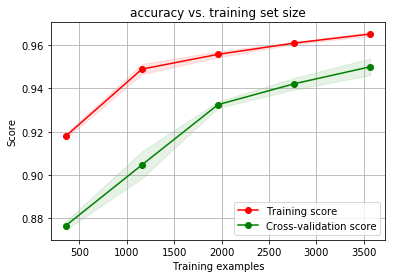

In [54]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5)

Como o desempenho continua crescendo, tanto para o treinamento quanto para os resultados de validação cruzada, vemos que nosso modelo não é complexo / flexível o suficiente para capturar todas as nuances, com poucos dados. Neste caso particular, não é muito pronunciado, já que as precisões são altas de qualquer maneira.

Neste ponto, temos duas opções:

1. use mais dados de treinamento, para superar a baixa complexidade do modelo
2. use um modelo mais complexo (menor tendência) para começar, para tirar mais proveito dos dados existentes

Ao longo dos últimos anos, as coleções de dados de treinamento maciço ficam mais disponíveis e, à medida que as máquinas ficam mais rápidas, a abordagem 1. está se tornando cada vez mais popular (algoritmos mais simples, mais dados). Os algoritmos simples, como o Naive Bayes, também têm o benefício adicional de serem mais fáceis de interpretar (em comparação com alguns modelos mais complexos, como caixa negra, como redes neurais).

Sabendo como avaliar modelos corretamente, agora podemos explorar como diferentes parâmetros afetam o desempenho.

## Etapa 6: como ajustar os parâmetros?

O que vimos até agora é apenas uma dica do iceberg: há muitos outros parâmetros para sintonizar. Um exemplo é o algoritmo a ser usado para treinamento.

Utilizamos Naive Bayes acima, mas scikit-learn suporta muitos classificadores fora da caixa: Support Vector Machines, Near Neighbours, Decision Trees, Ensamble methods 

[![](http://radimrehurek.com/data_science_python/drop_shadows_background.png)](http://peekaboo-vision.blogspot.cz/2013/01/machine-learning-cheat-sheet-for-scikit.html)

Podemos perguntar: Qual é o efeito da ponderação de IDF na precisão? O custo de processamento extra da lemmatização (vs. apenas palavras simples) realmente ajuda?

Vamos descobrir:

In [57]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [58]:
%time nb_detector = grid.fit(msg_train, label_train)
print(nb_detector.grid_scores_)

CPU times: user 2.53 s, sys: 98.2 ms, total: 2.63 s
Wall time: 13.3 s
[mean: 0.95021, std: 0.00386, params: {'bow__analyzer': <function split_into_lemmas at 0x119f66268>, 'tfidf__use_idf': True}, mean: 0.93294, std: 0.00194, params: {'bow__analyzer': <function split_into_lemmas at 0x119f66268>, 'tfidf__use_idf': False}, mean: 0.94685, std: 0.00352, params: {'bow__analyzer': <function split_into_tokens at 0x10d69dd08>, 'tfidf__use_idf': True}, mean: 0.92958, std: 0.00208, params: {'bow__analyzer': <function split_into_tokens at 0x10d69dd08>, 'tfidf__use_idf': False}]


(As melhores combinações de parâmetros são exibidas primeiro: neste caso, `use_idf = True` e` analyzer = split_into_lemmas` recebem o prêmio).

Um cheque rápido de sanidade:

In [60]:
print(nb_detector.predict_proba(["Hi mom, how are you?"])[0])
print(nb_detector.predict_proba(["WINNER! Credit for free!"])[0])

[ 0.99394303  0.00605697]
[ 0.36919226  0.63080774]


O `predict_proba` retorna a probabilidade prevista para cada classe (ham, spam). No primeiro caso, a mensagem deverá ser presumida com> 99% de probabilidade e spam com <1%. Então, se forçado a escolher, o modelo dirá "ham":

In [61]:
print(nb_detector.predict(["Hi mom, how are you?"])[0])
print(nb_detector.predict(["WINNER! Credit for free!"])[0])

ham
spam


E pontuações globais no conjunto de teste, o que não usamos durante o treinamento:

In [62]:
predictions = nb_detector.predict(msg_test)
print(confusion_matrix(label_test, predictions))
print(classification_report(label_test, predictions))

[[953   0]
 [ 68  94]]
             precision    recall  f1-score   support

        ham       0.93      1.00      0.97       953
       spam       1.00      0.58      0.73       162

avg / total       0.94      0.94      0.93      1115



Este é então o desempenho preditivo realista que podemos esperar do nosso pipeline de detecção de spam, ao usar minúsculas com lema, TF-IDF e Naive Bayes para classificador.

Vamos tentar com outro classificador: [Support Vector Machines (SVM)] (http://en.wikipedia.org/wiki/Support_vector_machine). Os SVMs são um excelente ponto de partida ao classificar dados de texto, obtendo resultados de ponta muito rapidamente e com um ajuste agradavelmente pequeno (embora um pouco mais do que Naive Bayes):

In [65]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [66]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm
print(svm_detector.grid_scores_)

CPU times: user 3.34 s, sys: 134 ms, total: 3.48 s
Wall time: 47.3 s
[mean: 0.98632, std: 0.00250, params: {'classifier__C': 1, 'classifier__kernel': 'linear'}, mean: 0.98699, std: 0.00329, params: {'classifier__C': 10, 'classifier__kernel': 'linear'}, mean: 0.98699, std: 0.00329, params: {'classifier__C': 100, 'classifier__kernel': 'linear'}, mean: 0.98699, std: 0.00329, params: {'classifier__C': 1000, 'classifier__kernel': 'linear'}, mean: 0.86880, std: 0.00006, params: {'classifier__C': 1, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}, mean: 0.86880, std: 0.00006, params: {'classifier__C': 1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}, mean: 0.86880, std: 0.00006, params: {'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}, mean: 0.86880, std: 0.00006, params: {'classifier__C': 10, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}, mean: 0.96928, std: 0.00270, params: {'classifier__C': 100, 'classifier__gamma': 0.001, 'cla

Então aparentemente, o kernel linear com `C = 1` é a melhor combinação de parâmetros.

Verificação de sanidade novamente:

In [67]:
print(svm_detector.predict(["Hi mom, how are you?"])[0])
print(svm_detector.predict(["WINNER! Credit for free!"])[0])

ham
spam


In [68]:
print(confusion_matrix(label_test, svm_detector.predict(msg_test)))
print(classification_report(label_test, svm_detector.predict(msg_test)))

[[951   2]
 [ 20 142]]
             precision    recall  f1-score   support

        ham       0.98      1.00      0.99       953
       spam       0.99      0.88      0.93       162

avg / total       0.98      0.98      0.98      1115



Este é então o desempenho preditivo realista que podemos esperar do nosso pipeline de detecção de spam, ao usar SVMs.


## Passo 7: Produzindo um preditor

Com a análise básica e o ajuste feito, o trabalho real (engenharia) começa.

O passo final para um preditor de produção seria treiná-lo em todo o conjunto de dados novamente, para aproveitar ao máximo todos os dados disponíveis. Usaremos os melhores parâmetros encontrados através da validação cruzada acima, é claro. Isso é muito semelhante ao que fizemos no início, mas desta vez tendo uma visão de seu comportamento e estabilidade. A avaliação foi realizada com honestidade, em diferentes divisões do subconjunto de treino/teste.

O preditor final pode ser serializado em disco, de modo que na próxima vez que quisermos usá-lo, podemos ignorar todos os treinamentos e usar o modelo treinado diretamente:

In [73]:
# store the spam detector to disk after training
with open('sms_spam_detector.pkl', 'wb') as fout:
    pickle.dump(svm_detector, fout)

# ...and load it back, whenever needed, possibly on a different machine
svm_detector_reloaded = pickle.load(open('sms_spam_detector.pkl','rb'))

O resultado carregado é um objeto que se comporta de forma idêntica ao original:

In [74]:
print('before:', svm_detector.predict([message4])[0])
print('after:', svm_detector_reloaded.predict([message4])[0])

before: ham
after: ham


Outra parte importante de uma implementação de produção é ** performance **. Após um ajuste de modelo rápido, iterativo e pesquisa de parâmetros, como mostrado aqui, um modelo bem performante pode ser traduzido para um idioma diferente e otimizado. O comércio de alguns pontos de precisão nos dará um modelo menor e mais rápido? Vale a pena otimizar o uso da memória, talvez usando o `mmap` para compartilhar memória em todos os processos?

Observe que a otimização nem sempre é necessária; Comece sempre com o perfil real.

Outras coisas a considerar aqui, para um pipeline de produção, são ** robustez ** (failover de serviço, redundância, balanceamento de carga), ** monitoramento ** (incluindo alertas automáticos em anomalias) e ** Fungibilidade de RH ** (evitando "Silos de conhecimento" de como as coisas são feitas, tecnologias arcanas / lock-in, arte negra de resultados de ajuste). Hoje em dia, mesmo o mundo de código aberto pode oferecer soluções viáveis em todas essas áreas. Toda a ferramenta mostrada hoje é gratuita para uso comercial, sob licenças de código aberto aprovadas pela OSI.